# 와인 품질 분류 경진대회 🍷

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost
!pip install kaggler
!pip install pendulum
!pip install flaml
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import datetime
np.random.seed(0)

from kaggler.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss

from tqdm.notebook import tqdm
import os, re
import glob
import calendar

from flaml import AutoML
import statsmodels.api as sm
import pendulum
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_row', 526)
pd.set_option('display.max_columns', 100)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic'
%config inlinebackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

pd.set_option('display.max_row', 526)
pd.set_option('display.max_columns', 100)

# Data Load

In [ ]:
path = '/content/drive/MyDrive/wine/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

train.columns = ['id', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type',
       'quality']

test.columns = ['id', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'type']

In [ ]:
test.columns

Index(['id', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'type'],
      dtype='object')

In [ ]:
train['quality'].unique()

array([6, 7, 5, 8, 4])

In [ ]:
def data_feature(df):
    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()
    df['type'] = le.fit_transform(df['type'])


    return df

In [ ]:
train = data_feature(train)
test = data_feature(test)

In [ ]:
train.columns

Index(['id', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type',
       'quality'],
      dtype='object')

In [ ]:
test.columns

Index(['id', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'type'],
      dtype='object')

In [ ]:
train_0 = train[train['type'] == 0]
train_1 = train[train['type'] == 1]
train_0.drop(columns=['id'], inplace=True)
train_1.drop(columns=['id'], inplace=True)
train_0.reset_index(drop=True, inplace=True)
train_1.reset_index(drop=True, inplace=True)

In [ ]:
train['quality'].unique()

array([6, 7, 5, 8, 4])

In [ ]:
test.columns

Index(['id', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'type'],
      dtype='object')

## Outlier 제거

In [ ]:
for i in train['quality'].unique():
    globals()['train_{}'.format(i)] = train[train['quality'] == i]
    locals()['train_{}'.format(i)].drop(columns=['id'], inplace=True)
    locals()['train_{}'.format(i)].reset_index(drop=True, inplace=True)

In [ ]:
for i in train['quality'].unique():
    for j in train['type'].unique():
        globals()['train_{}'.format(i)] = train[train['quality'] == i]
    locals()['train_{}'.format(i)].drop(columns=['id'], inplace=True)
    locals()['train_{}'.format(i)].reset_index(drop=True, inplace=True)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


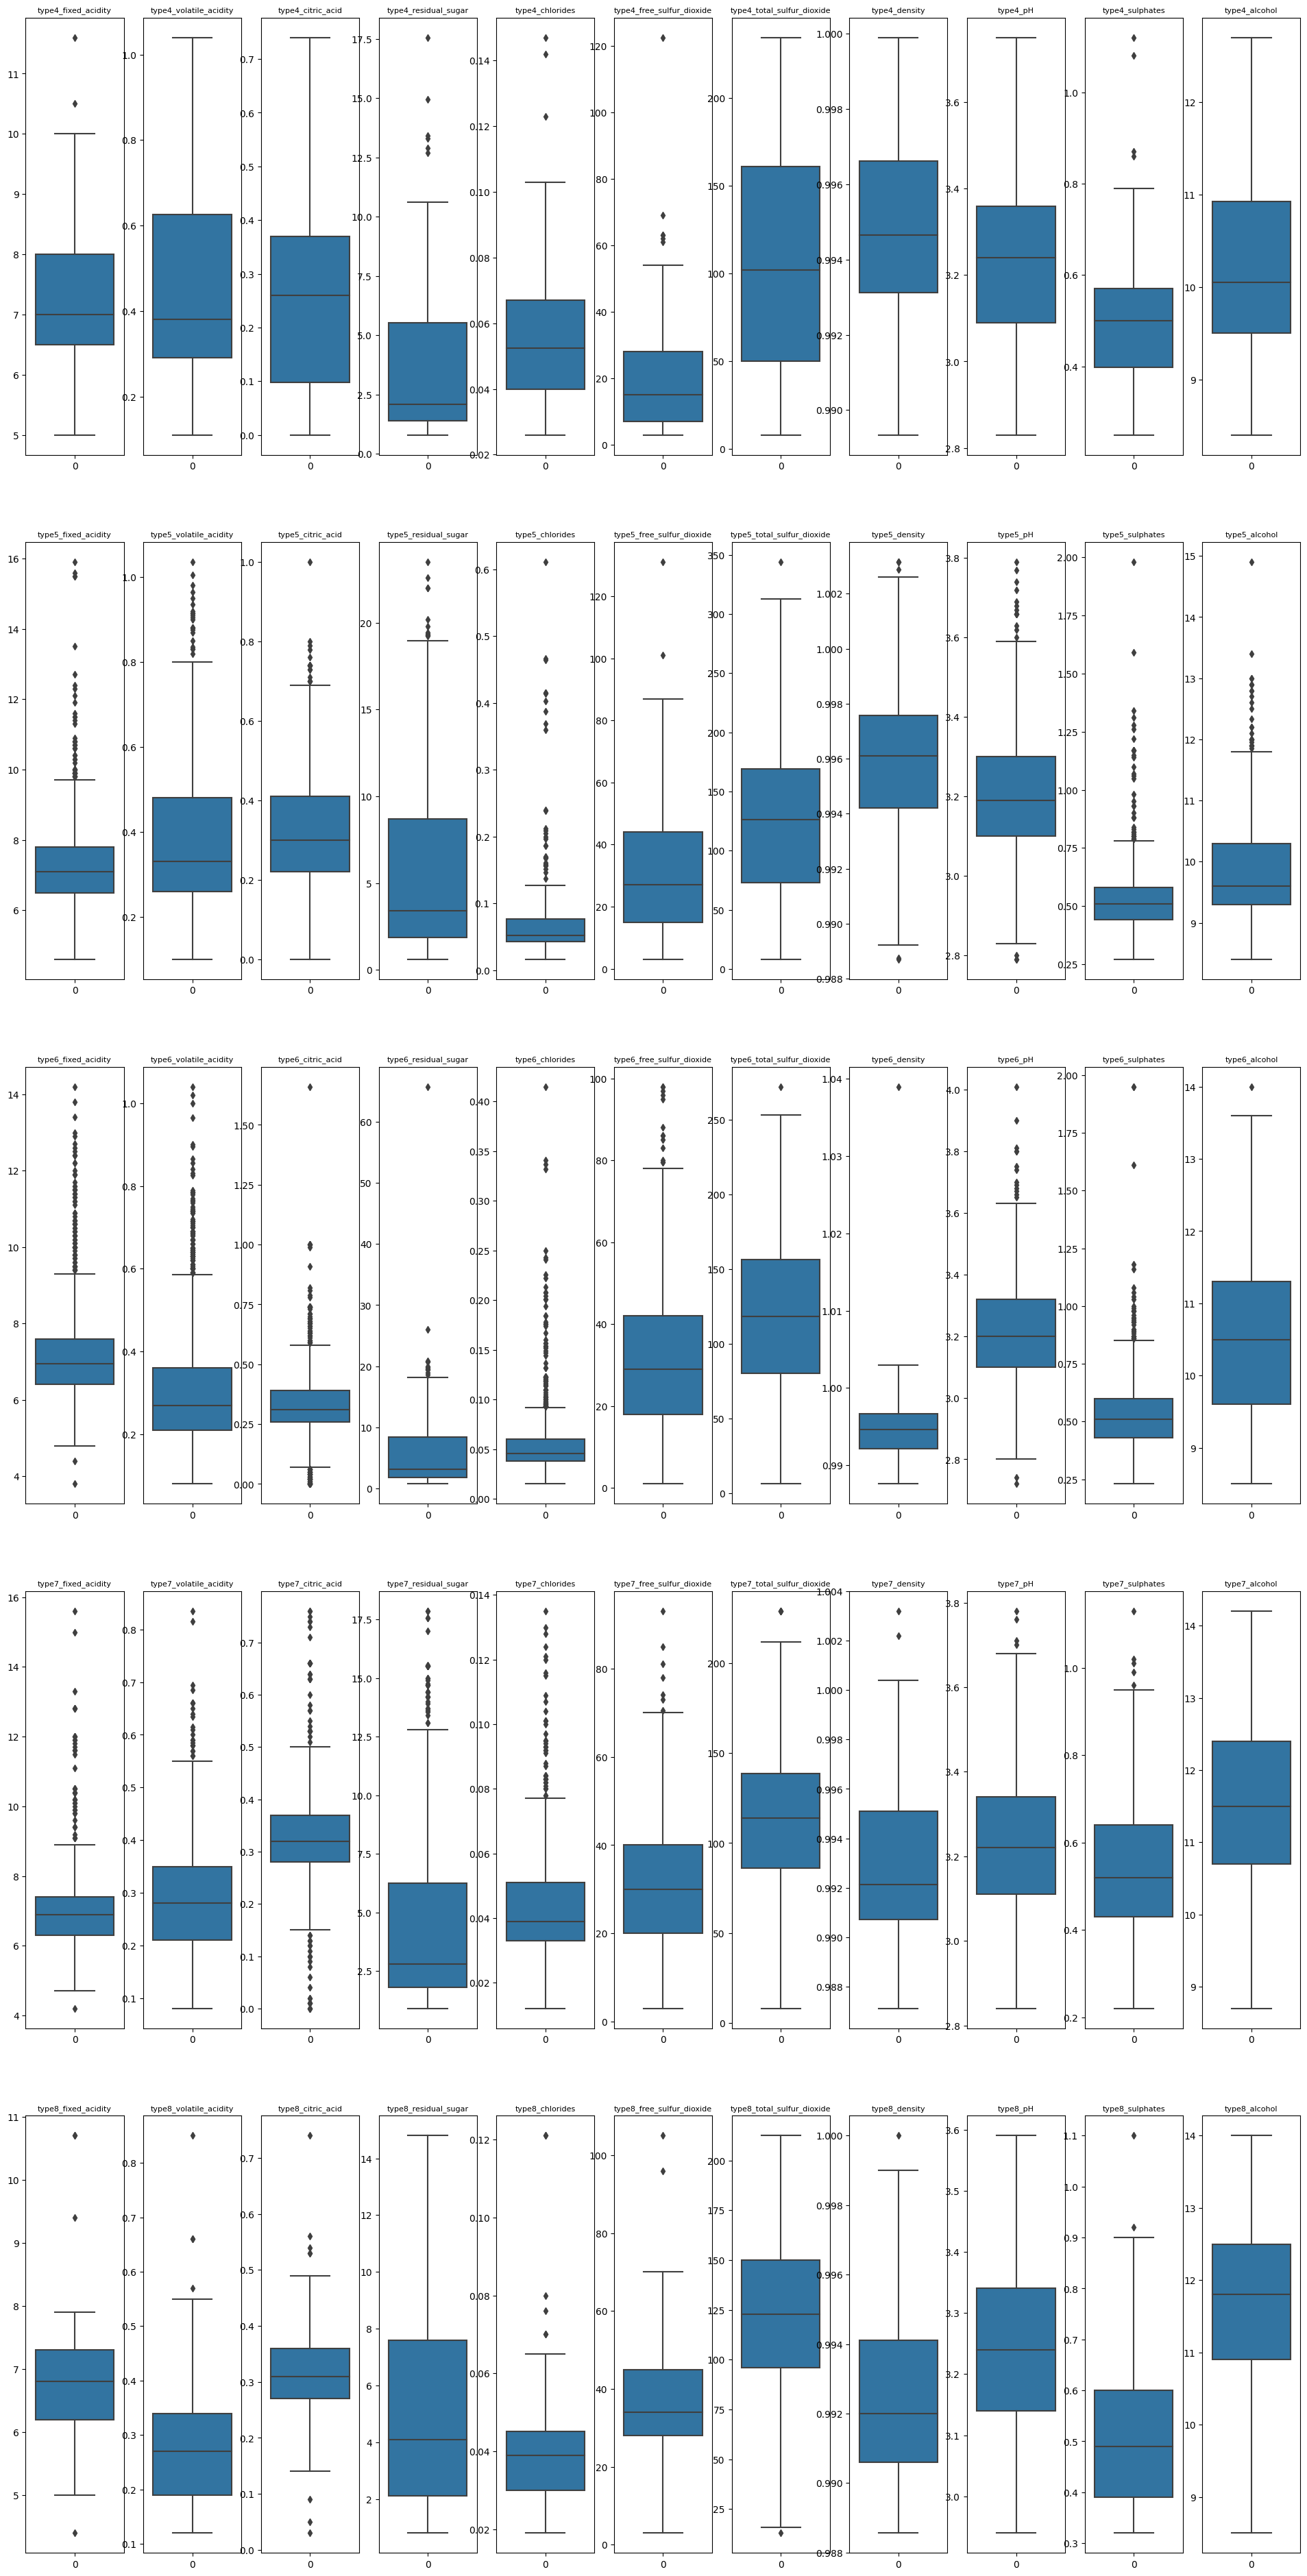

In [ ]:
plt.figure(figsize=(24,49))
count = 1
for i in sorted(train['quality'].unique()):
    for j in test.columns[1:12]:
        plt.subplot(5,11,count)
        p = sns.boxplot(data=locals()['train_{}'.format(i)][j])
        p.set_title(f'type{i}_{j}', fontsize=8)
        count+=1
plt.show()

In [ ]:
outlier_idx = set()

In [ ]:
# quality = 4
for i in train[train.quality == 4].fixed_acidity[train[train.quality == 4].fixed_acidity >= 11].index.values:
    outlier_idx.add(i)
# for i in train[train.quality == 5].volatile_acidity[train[train.quality == 5].volatile_acidity >= 0.92].index.values:
#     outlier_idx.add(i)
# for i in train[train.quality == 5].citric_acid[train[train.quality == 5].citric_acid >= 0.9].index.values:
#     outlier_idx.add(i)
for i in train[train.quality == 4].residual_sugar[train[train.quality == 4].residual_sugar >= 12.5].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 4].chlorides[train[train.quality == 4].chlorides >= 0.12].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 4].free_sulfur_dioxide[train[train.quality == 4].free_sulfur_dioxide >= 120].index.values:
    outlier_idx.add(i)
# for i in train[train.quality == 5].density[train[train.quality == 5].density >= 1.03].index.values:
#     outlier_idx.add(i)
# for i in train[train.quality == 5].PH[train[train.quality == 5].PH >= 3.9].index.values:
#     outlier_idx.add(i)
for i in train[train.quality == 4].sulphates[train[train.quality == 4].sulphates >= 1.0].index.values:
    outlier_idx.add(i)


# quality = 5
for i in train[train.quality == 5].fixed_acidity[train[train.quality == 5].fixed_acidity >= 14].index.values:
    outlier_idx.add(i)
# for i in train[train.quality == 5].volatile_acidity[train[train.quality == 5].volatile_acidity >= 0.92].index.values:
#     outlier_idx.add(i)
for i in train[train.quality == 5].citric_acid[train[train.quality == 5].citric_acid >= 0.9].index.values:
    outlier_idx.add(i)
# for i in train[train.quality == 5].residual_sugar[train[train.quality == 5].residual_sugar >= 60].index.values:
#     outlier_idx.add(i)
for i in train[train.quality == 5].chlorides[train[train.quality == 5].chlorides >= 0.30].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 5].free_sulfur_dioxide[train[train.quality == 5].free_sulfur_dioxide >= 120].index.values:
    outlier_idx.add(i)
# for i in train[train.quality == 5].density[train[train.quality == 5].density >= 1.03].index.values:
#     outlier_idx.add(i)
# for i in train[train.quality == 5].PH[train[train.quality == 5].PH >= 3.9].index.values:
#     outlier_idx.add(i)
for i in train[train.quality == 5].sulphates[train[train.quality == 5].sulphates >= 1.50].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 5].alcohol[train[train.quality == 5].alcohol >= 14].index.values:
    outlier_idx.add(i)

# quality = 6
for i in train[train.quality == 6].fixed_acidity[train[train.quality == 6].fixed_acidity >= 13].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].volatile_acidity[train[train.quality == 6].volatile_acidity >= 0.92].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].citric_acid[train[train.quality == 6].citric_acid >= 1.25].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].residual_sugar[train[train.quality == 6].residual_sugar >= 60].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].chlorides[train[train.quality == 6].chlorides >= 0.30].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].free_sulfur_dioxide[train[train.quality == 6].free_sulfur_dioxide >= 90].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].density[train[train.quality == 6].density >= 1.03].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].pH[train[train.quality == 6].pH >= 3.9].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 6].sulphates[train[train.quality == 6].sulphates >= 1.50].index.values:
    outlier_idx.add(i)

# quality = 7
for i in train[train.quality == 7].fixed_acidity[train[train.quality == 7].fixed_acidity >= 14].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].volatile_acidity[train[train.quality == 7].volatile_acidity >= 0.75].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].citric_acid[train[train.quality == 7].citric_acid >= 0.7].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].residual_sugar[train[train.quality == 7].residual_sugar >= 16].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].chlorides[train[train.quality == 7].chlorides >= 0.11].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].free_sulfur_dioxide[train[train.quality == 7].free_sulfur_dioxide >= 90].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].density[train[train.quality == 7].density >= 1.002].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 7].sulphates[train[train.quality == 7].sulphates >= 1.1].index.values:
    outlier_idx.add(i)

# quality = 8
for i in train[train.quality == 8].fixed_acidity[train[train.quality == 8].fixed_acidity >= 9].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 8].volatile_acidity[train[train.quality == 8].volatile_acidity >= 0.7].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 8].citric_acid[train[train.quality == 8].citric_acid >= 0.6].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 8].chlorides[train[train.quality == 8].chlorides >= 0.1].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 8].free_sulfur_dioxide[train[train.quality == 8].free_sulfur_dioxide >= 80].index.values:
    outlier_idx.add(i)
for i in train[train.quality == 8].sulphates[train[train.quality == 8].sulphates >= 1.0].index.values:
    outlier_idx.add(i)

In [ ]:
train.drop(outlier_idx, axis=0, inplace=True)

In [ ]:
train = train.reset_index(drop=True)

In [ ]:
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [ ]:
import numpy as np
import shap
def get_columns(model, X_test, train, del_col_nm='quality'):
  explainer = shap.Explainer(model._model)
  shap_values = explainer(X_test)
  vals = np.abs(shap_values.values).mean(0)
  cols = list(train.columns)
  cols.remove(del_col_nm)
  feature_importance = pd.DataFrame(list(zip(cols, vals)), columns=['col_name','feature_importance_vals'])
  feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
  return feature_importance[feature_importance['feature_importance_vals'] > 1]['col_name'].values

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def run_kfold(train, test, selected_cols=[], target_col='중식계'):
    folds=KFold(n_splits=5, shuffle=True, random_state=2021)
    outcomes=[]
    model = None
    sub=[]

    # X = None
    # X_test = None
    # if len(selected_cols) > 0:
    #   X = np.array(train[selected_cols])
    #   X_test = np.array(test[selected_cols])
    # else:
    #   X = np.array(train.drop(columns=[target_col]))
    #   cols = list(train.columns)
    #   cols.remove(target_col)
    #   X_test = np.array(test[cols])

    # y = np.array(train[target_col])
    X = np.array(train.drop(columns=[target_col]))
    cols = list(train.columns)
    cols.remove(target_col)
    X_test = np.array(test[cols])
    y = np.array(train[target_col])

    # 정규화
    standardScaler = StandardScaler()
    standardScaler.fit(X)
    X = standardScaler.transform(X)

    X_test = standardScaler.transform(X_test) # 정규화
    cols_import = []

    for n_fold, (train_index, val_index) in enumerate(folds.split(X)):
        print(n_fold, 'fold started =========================================')
        # X_train1, X_val = , X_train.loc[val_index]
        y_train = y[train_index]
        X_train = X[train_index]
        # y_train1, y_val = y_train.loc[train_index], y_train.loc[val_index]
        y_val = y[val_index]
        X_val = X[val_index]
        if n_fold == 0:
          automl = AutoML()
          automl_settings = {
              "time_budget": 360,  # in seconds
              "metric": 'mae',
              "task": 'regression'
          }
          automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)
          model = automl.model
        else:
          model.fit(X_train, y_train, 
                    eval_set=[(X_val, y_val)],
                        eval_metric='mae', 
                    early_stopping_rounds=10
                    ) 
        
        pred1 = model.predict(X_test)
        if len(selected_cols) == 0:
          cols_import += list(get_columns(model, X_test, train=train, del_col_nm=target_col))
        sub.append(pred1)
    return sub, model, X_test, set(cols_import)

In [ ]:
my_submission, model, X_test, cols_import = run_kfold(train, test, selected_cols=[], target_col='quality')

[flaml.automl: 12-02 02:45:47] {1926} INFO - task = regression
[flaml.automl: 12-02 02:45:47] {1928} INFO - Data split method: uniform
[flaml.automl: 12-02 02:45:47] {1932} INFO - Evaluation method: holdout
[flaml.automl: 12-02 02:45:47] {1999} INFO - Minimizing error metric: mae
[flaml.automl: 12-02 02:45:47] {2051} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 12-02 02:45:47] {2291} INFO - iteration 0, current learner lgbm


0 fold started =========================================


[flaml.automl: 12-02 02:45:48] {2405} INFO - Estimated sufficient time budget=2766s. Estimated necessary time budget=24s.
[flaml.automl: 12-02 02:45:48] {2485} INFO -  at 0.3s,	estimator lgbm's best error=0.6019,	best estimator lgbm's best error=0.6019
[flaml.automl: 12-02 02:45:48] {2291} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-02 02:45:48] {2485} INFO -  at 0.3s,	estimator lgbm's best error=0.6019,	best estimator lgbm's best error=0.6019
[flaml.automl: 12-02 02:45:48] {2291} INFO - iteration 2, current learner lgbm
[flaml.automl: 12-02 02:45:48] {2485} INFO -  at 0.4s,	estimator lgbm's best error=0.5785,	best estimator lgbm's best error=0.5785
[flaml.automl: 12-02 02:45:48] {2291} INFO - iteration 3, current learner lgbm
[flaml.automl: 12-02 02:45:48] {2485} INFO -  at 0.4s,	estimator lgbm's best error=0.5470,	best estimator lgbm's best error=0.5470
[flaml.automl: 12-02 02:45:48] {2291} INFO - iteration 4, current learner lgbm
[flaml.automl: 12-02 02:45:48] {2485} 

1 fold started =========================================
2 fold started =========================================
3 fold started =========================================
4 fold started =========================================


In [ ]:
pred = np.mean(my_submission, axis=0)

In [ ]:
sample_submission = pd.read_csv(path+'sample_submission.csv')
submission = sample_submission.copy()

In [ ]:
submission['quality'] = pred

In [ ]:
submission['quality'] = round(submission['quality'], 0)

In [ ]:
submission.to_csv(path + 'automl.csv', index=False)

In [ ]:
submission

,id,quality
0,1,6.0
1,2,6.0
2,3,6.0
3,4,6.0
4,5,5.0
...,...,...
3226,3227,5.0
3227,3228,6.0
3228,3229,5.0
3229,3230,7.0
